In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dpmm
import prior
%matplotlib inline

In [2]:
class gaussND(object):
    def __init__(self, mu, Sigma):
        self.mu = mu
        self.Sigma = Sigma
        self.d = len(self.mu)

    def sample(self, size=None):
        return np.random.multivariate_normal(mean=self.mu, cov=self.Sigma, size=size)

class MM(object):
    def __init__(self, components, proportions):
        self.components = components
        self.proportions = proportions
        self.d = self.components[0].d

    def sample(self, size=None):
        if size is None:
            nums = np.random.multinomial(1, self.proportions)
            c = num.index(1) # which class got picked
            return self.components[c].sample()
        else:
            out = np.empty((size, self.d), dtype=float)
            nums = np.random.multinomial(size, self.proportions)
            i = 0
            for component, num in zip(self.components, nums):
                out[i:i+num] = component.sample(size=num)
                i += num
            return out

In [3]:
# Mixture model parameters
mu = [np.r_[0.0, 0.0], np.r_[1.0, 1.0], np.r_[0., 1.0]]
Sigma = [np.eye(2)*0.1**2, np.eye(2)*0.2**2, np.eye(2)*0.2**2]
p = [0.25, 0.4, 0.35]
model = MM([gaussND(mu0, Sigma0) for mu0, Sigma0 in zip(mu, Sigma)], p)

/Users/josh/miniconda2/lib/python2.7/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/Users/josh/miniconda2/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


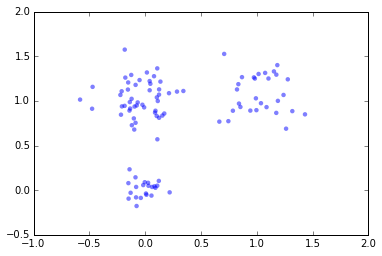

In [4]:
# Generate some data and plot it
data = model.sample(size=100)
f = plt.figure(figsize=(6,4))
ax = f.add_subplot(111)
ax.scatter(data[:,0], data[:,1], alpha=0.5)
f.show()

In [5]:
# Make DPMM
mu_0 = np.r_[0.5, 0.5]
kappa_0 = 1.1
Lam_0 = np.eye(2)*2
nu_0 = 2

cp = prior.NIW(mu_0, kappa_0, Lam_0, nu_0)
dp = dpmm.DPMM2(cp, 1.0, data)

In [6]:
# Burn-in
dp.update(100)

In [7]:
# Sample
phis = []
nphis = []
# Sample
for i in xrange(10):
    dp.update(10)
    phis.append(list(dp.phi)) # Need list() to get a copy
    nphis.append(list(dp.nphi))

In [8]:
# Stole this from http://stackoverflow.com/questions/9081553/python-scatter-plot-size-and-style-of-the-marker/24567352#24567352
# Need to add covariances in data units.

def circles(x, y, s, c='b', ax=None, vmin=None, vmax=None, **kwargs):
    """
    Make a scatter of circles plot of x vs y, where x and y are sequence 
    like objects of the same lengths. The size of circles are in data scale.

    Parameters
    ----------
    x,y : scalar or array_like, shape (n, )
        Input data
    s : scalar or array_like, shape (n, ) 
        Radius of circle in data scale (ie. in data unit)
    c : color or sequence of color, optional, default : 'b'
        `c` can be a single color format string, or a sequence of color
        specifications of length `N`, or a sequence of `N` numbers to be
        mapped to colors using the `cmap` and `norm` specified via kwargs.
        Note that `c` should not be a single numeric RGB or
        RGBA sequence because that is indistinguishable from an array of
        values to be colormapped.  `c` can be a 2-D array in which the
        rows are RGB or RGBA, however.
    ax : Axes object, optional, default: None
        Parent axes of the plot. It uses gca() if not specified.
    vmin, vmax : scalar, optional, default: None
        `vmin` and `vmax` are used in conjunction with `norm` to normalize
        luminance data.  If either are `None`, the min and max of the
        color array is used.  (Note if you pass a `norm` instance, your
        settings for `vmin` and `vmax` will be ignored.)

    Returns
    -------
    paths : `~matplotlib.collections.PathCollection`

    Other parameters
    ----------------
    kwargs : `~matplotlib.collections.Collection` properties
        eg. alpha, edgecolors, facecolors, linewidths, linestyles, norm, cmap

    Examples
    --------
    a = np.arange(11)
    circles(a, a, a*0.2, c=a, alpha=0.5, edgecolor='none')

    License
    --------
    This code is under [The BSD 3-Clause License]
    (http://opensource.org/licenses/BSD-3-Clause)
    """
    from matplotlib.patches import Circle
    from matplotlib.collections import PatchCollection
    import pylab as plt
    #import matplotlib.colors as colors

    if ax is None:
        ax = plt.gca()    

    if isinstance(c,basestring):
        color = c     # ie. use colors.colorConverter.to_rgba_array(c)
    else:
        color = None  # use cmap, norm after collection is created
    kwargs.update(color=color)

    if np.isscalar(x):
        patches = [Circle((x, y), s),]
    elif np.isscalar(s):
        patches = [Circle((x_,y_), s) for x_,y_ in zip(x,y)]
    else:
        patches = [Circle((x_,y_), s_) for x_,y_,s_ in zip(x,y,s)]
    collection = PatchCollection(patches, **kwargs)

    if color is None:
        collection.set_array(np.asarray(c))
        if vmin is not None or vmax is not None:
            collection.set_clim(vmin, vmax)

    ax.add_collection(collection)
    ax.autoscale_view()
    return collection

def ellipses(x, y, s, q, pa, c='b', ax=None, vmin=None, vmax=None, **kwargs):
    """Scatter plot of ellipses.
    
    (x, y) duh.
    s      size.
    q      axes ratio b/a
    pa     position angle CCW in deg.
    """
    from matplotlib.patches import Ellipse
    from matplotlib.collections import PatchCollection
    import pylab as plt
    #import matplotlib.colors as colors

    if ax is None:
        ax = plt.gca()    

    if isinstance(c,basestring):
        color = c     # ie. use colors.colorConverter.to_rgba_array(c)
    else:
        color = None  # use cmap, norm after collection is created
    kwargs.update(color=color)

    w, h = s*np.sqrt(q), s/np.sqrt(q)
    
    if np.isscalar(x):
        patches = [Ellipse((x, y), w, h, pa),]
    else:
        patches = [Ellipse((x_,y_), w_, h_, pa_) for x_,y_,w_,h_,pa_ in zip(x,y,w,h,pa)]
    collection = PatchCollection(patches, **kwargs)

    if color is None:
        collection.set_array(np.asarray(c))
        if vmin is not None or vmax is not None:
            collection.set_clim(vmin, vmax)

    ax.add_collection(collection)
    ax.autoscale_view()
    return collection    

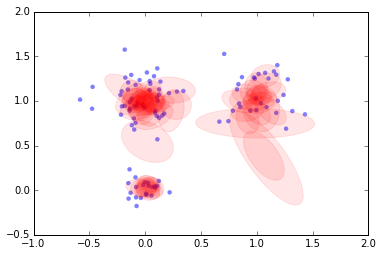

In [9]:
def plot_sample(phi, nphi, axis=None, **kwargs):
    if axis is None:
        axis = plt.gca()
    for ph, n in zip(phi, nphi):
        val, vec = np.linalg.eigh(ph[1])
        # 5.991 gives 95% ellipses
        s = np.sqrt(np.sqrt(5.991*val[0]*val[1]))
        q = np.sqrt(val[0]/val[1])
        pa = np.arctan2(vec[0,1], vec[0,0])*180/np.pi
        # Need to incorporate the covariance of the circles....
        # s = np.linalg.det(ph[1])**(1./4)
#         circles(ph[0][0], ph[0][1], s, **kwargs)
        ellipses(ph[0][0], ph[0][1], s, q, pa, **kwargs)

# Overplot samples.
f = plt.figure(figsize=(6,4))
ax = f.add_subplot(111)
ax.scatter(data[:,0], data[:,1], alpha=0.5)
for phi, nphi in zip(phis, nphis):
    plot_sample(phi, nphi, axis=ax, c='r', alpha=0.1)
f.show()

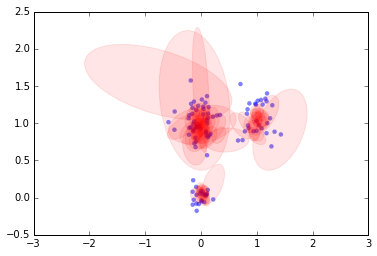

In [10]:
# Sample some more and plot again.
phis = []
nphis = []
# Sample
for i in xrange(10):
    dp.update(10)
    phis.append(list(dp.phi)) # Need list() to get a copy
    nphis.append(list(dp.nphi))
    
f = plt.figure(figsize=(6,4))
ax = f.add_subplot(111)
ax.scatter(data[:,0], data[:,1], alpha=0.5)
for phi, nphi in zip(phis, nphis):
    plot_sample(phi, nphi, axis=ax, c='r', alpha=0.1)
f.show()

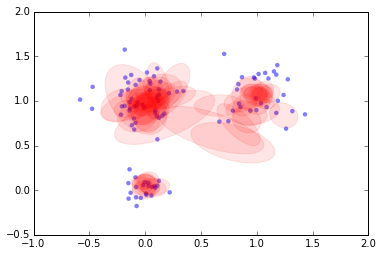

In [11]:
# Sample some more and plot again.
phis = []
nphis = []
# Sample
for i in xrange(10):
    dp.update(10)
    phis.append(list(dp.phi)) # Need list() to get a copy
    nphis.append(list(dp.nphi))
    
f = plt.figure(figsize=(6,4))
ax = f.add_subplot(111)
ax.scatter(data[:,0], data[:,1], alpha=0.5)
for phi, nphi in zip(phis, nphis):
    plot_sample(phi, nphi, axis=ax, c='r', alpha=0.1)
f.show()

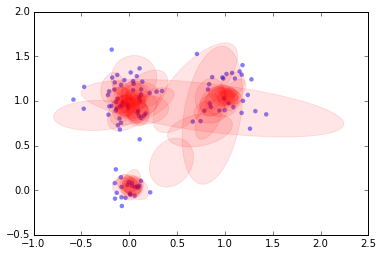

In [12]:
# Sample some more and plot again.
phis = []
nphis = []
# Sample
for i in xrange(10):
    dp.update(10)
    phis.append(list(dp.phi)) # Need list() to get a copy
    nphis.append(list(dp.nphi))
    
f = plt.figure(figsize=(6,4))
ax = f.add_subplot(111)
ax.scatter(data[:,0], data[:,1], alpha=0.5)
for phi, nphi in zip(phis, nphis):
    plot_sample(phi, nphi, axis=ax, c='r', alpha=0.1)
f.show()